# Índice
1. [Importación de Dependencias](#importación-de-dependencias)
2. [Configuración del Notebook](#configuración-del-notebook)
    1. [Configuración Global](#configuracion-global)
    2. [Configuración de la Predicción](#configuracion-de-la-prediccion)
    3. [Configuración de Hiperparámetros](#configuracion-de-hiperparametros)
3. [Funciones Auxiliares](#funciones-auxiliares)
    1. [getDataFramesForTrainAndTest()](#getdataframesfortrainandtest)
    2. [getMegaDF()](#getmegadf)
    3. [adjustDataFrameForUseCase()](#adjustdataframeforusecase)
    4. [enrichDF()](#enrichdf)
    5. [mlflowLoadRun() y mlflowRegistrarRun()](#mlflowloadrun-y-mlflowregistrarrun)
4. [Creación del CSV Agregado](#creación-del-csv-agregado)
    1. [Enriquecimiento del DataSet](#enriquecimiento-del-dataset)
5. [Preprocesamiento de Datos](#preprocesamiento-de-datos)
    1. [Implementación de Pipeline SimpleImputer y StandarScaller](#implementación-de-pipeline-simpleimputer-y-standarscaller)
    2. [Transformación de las características numéricas](#transformación-de-las-características-numéricas)
    3. [Evaluación visual de la transformación de los datos](#evaluación-visual-de-la-transformación-de-los-datos)
    4. [Evaluación de las características](#evaluación-de-las-características)
       1. [PCA - Análisis de Componentes Principales](#pca---análisis-de-componentes-principales)
6.[Hiperparametros](#hiperparametros)
    1. [Modelos](#modelos)
       1. [LinearRegression](#linearregression)
       2. [Lasso](#Lasso)
       3. [DecisionTreeRegressor](#decisiontreeregressor)
       4. [RandomForestRegressor](#randomforestregressor)
    2. [Ejecución conjunta de los modelos](#ejecución-conjunta-de-los-modelos)


# Importación de dependencias

In [1]:
import pandas as pd
import time
import  os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore') 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from IPython.display import display
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
# Pipelines Dependencies
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import seaborn as sns
# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from IPython.core.display import HTML
from mlflow import MlflowClient
from pprint import pprint
import multiprocessing
import mlflow
from sklearn import metrics

# Configuración del Notebook

## Configuración Global

In [2]:
# Configuración de Directorios
data_directory = "/data"
csv_evaluation_resume = "csv_evaluation_resume_modelos_gridsearch.csv"
store_csv_path = data_directory + "/store.csv"
store_data_csv_path = data_directory + "/store-data.csv"

# Configuramos el número de ventanas temporales y los días que se recuperan del
# dataset global.
windows = [
    7, 
    90
]

# Configuramos por cada ventana temporal el porcentaje de datos que se usarán
# para el entrenamiento.
percents_by_windows = [
    0.8
]

# Cargamos los ficheros CSV en DataFrames de pandas
storeDF = pd.read_csv(store_csv_path)
storeDataDF = pd.read_csv(store_data_csv_path)

# Esta variable permite definir las columnas que se eliminarán del DataFrame
# que no vamos a usar en el TFM en ningún caso de uso.
columns_to_drop = [
]

# Esta variable permite definir el porcentaje de datos que se usarán para 
# el entrenamiento
percent_train = 0.8

scoring = {'r2':'r2','rmae':'neg_root_mean_squared_error','mae':'neg_mean_squared_error'}



## Configuración de la Predicción

In [3]:
# Con el DataSet enriquecido, esta variable nos permite seleccionar
# que columnas queremos usar para el entrenamiento
columns_for_inference = [
    "StoreType",
    "Assortment",
    "Promo2", 
    "Promo2SinceWeek",	
    "Promo2SinceYear",
    "DayOfWeek", 
    "Customers",	
    "Open",	
    "Promo",	
    "StateHoliday",
    "SchoolHoliday",
    "SalesDay",
    "SalesMonth",
    "SalesYear",
    "PromoIntervalMonth1", 
    "PromoIntervalMonth2", 
    "PromoIntervalMonth3", 
    "PromoIntervalMonth4",
    "CompetitionOpenSinceYear",
    "CompetitionDistance",
    "CompetitionOpenSinceMonth"
]

# Esta variable define que columna que se usará para predecir
column_to_predict = 'Sales'

## Configuración de Hiperparámetros
En esta sección se configuran los hiperparámetros que utilizarán los modelos de predicción

In [4]:
pipeline_random_state = 42

# Funciones Auxiliares
En esta sección están codificadas las funciones auxiliares que necesita el motor de evaluación.

## getDataFramesForTrainAndTest()
Esta función se encarga de obtener los datos de entrenamiento y test a partir del dataframe
generado por la función anterior, permitiendo decidir en esta función, que columnas se usarán
para inferir y cual se utilizará para predecir. Los argumentos que recibe son:
- `dataFrame`: DataFrame que contiene los datos mergeados de los ficheros CSV.
- `percent_train`: Porcentaje de datos que se utilizarán para entrenar
- `columns_for_inference`: columnas que se utilizarán para inferir en los datos de entrenamiento y test
- `column_to_predict`: columna que se utilizará para predecir en los datos de entrenamiento y test

In [5]:
def getDataFramesForTrainAndTest(dataFrame, 
                                 percent_train, 
                                 columns_for_inference, 
                                 column_to_predict): 

    features = dataFrame[columns_for_inference]
    target = dataFrame[[column_to_predict]]

    return train_test_split(features, 
                            target, 
                            test_size=(1.0-percent_train), 
                            random_state=0)

## getMegaDF()
Esta función se encarga de obtener un Mega DataFrame (megaDF), unión de los dos CSV's en fichero y de eliminar aquellas columnas que no se usarán en ningún caso de uso del TFM
- `storeDF`: DataFrame que contiene los datos del archivo store.csv
- `storeDataDF`: DataFrame que contiene los datos del archivo store-data.csv
- `columns_to_drop`: Lista de columnas que queremos eliminar del Mega DataFrame

In [6]:
def getMegaDF(storeDF, 
              storeDataDF, 
              columns_to_drop):

    # Para poder tener todos los datos de entrada en una sola tabla 
    # mergeamos el DataFrame storeDF con el DataFrame storeDataDF 
    # por la columna Store
    megaDF = storeDF.merge(storeDataDF, on='Store')

    # Eliminamos las columnas del DataFrame mergeado que no
    # vamos a usar para la inferencia
    megaDF = megaDF.drop(columns=columns_to_drop)
    
    # Eliminamos las filas que contienen valores nulos
    # megaDF = megaDF.dropna() ojo
    
    # Reajustamos el tipo de la columna Date a datetime
    megaDF['Date'] = pd.to_datetime(megaDF['Date'])
        
    return megaDF

## adjustDataFrameForUseCase()
Esta función se encarga de ajustar el Mega DataFrame original al caso de uso que se quiere analizar en el TFM. Los argumentos de entrada que recibe son:
- `megaDF`: Mega DataFrame original de la unión de los CSV's sin las columnas innecesarias
- `last_no_days`: Número de días que queremos obtener a partir de la fecha más reciente
- `percent_of_returned_rows`: Porcentaje de filas que queremos obtener del DataFrame mergeado

In [7]:

def adjustDataFrameForUseCase(megaDF, 
                              last_no_days, 
                              percent_of_returned_rows):

    # Determinamos la fecha más reciente del DataFrame storeDataDF que nos 
    # servirá como pivote para obtener los datos de los últimos last_no_days días
    last_date = megaDF['Date'].max()

    # Determinamos la fecha mínima desde la cual queremos obtener registros
    # del DataFrame storeDataDF
    minDate = pd.to_datetime(last_date) - pd.DateOffset(days=last_no_days)

    # Reajustamos el tipo de la columna Date a datetime
    # megaDF['Date'] = pd.to_datetime(megaDF['Date']) ojo

    # Obtenemos los datos de storeDataDF a partir de la fecha minDate hasta la
    # fecha más reciente o last_date    
    megaDF = megaDF[megaDF['Date'] > minDate]

    # Obtener un porcentaje del total de filas del DataFrame
    # para poder hacer pruebas
    megaDF = megaDF.sample(frac=percent_of_returned_rows)
        
    return megaDF

## enrichDF()
Esta función la utilizaremos para enriquecer el CSV Agregado (megaDF) con nuevas columnas a partir de los datos que ya contiene y para convertir las columnas categóricas en columnas numéricas.
- `sourceDF`: Mega DataFrame que se va a enriquecer

In [8]:

def enrichDF(sourceDF):
    
    sourceDF['Date'] = pd.to_datetime(sourceDF['Date'])  # Ensure the Date column is in datetime format
    
    # Hacemos split de la columna Date en tres columnas nuevas: SalesDay, SalesMonth y SalesYear, que
    # permiten usar como numérico la fecha en String.
    sourceDF['SalesDay'] = sourceDF['Date'].dt.day
    sourceDF['SalesMonth'] = sourceDF['Date'].dt.month
    sourceDF['SalesYear'] = sourceDF['Date'].dt.year
    
    # Mapeamos los valores categóricos de la columna PromoInterval a valores numéricos
    month_mapping = {
        None:0, 
        'Jan': 1, 
        'Feb': 2, 
        'Mar': 3, 
        'Apr': 4, 
        'May': 5, 
        'Jun': 6, 
        'Jul': 7, 
        'Aug': 8, 
        'Sept': 9, 
        'Oct': 10, 
        'Nov': 11, 
        'Dec': 12
    }
    
    # Definimos las nuevas columnas a crear para cada valor de la columna PromoInterval
    promo_interval_columns = [
        'PromoIntervalMonth1', 
        'PromoIntervalMonth2', 
        'PromoIntervalMonth3', 
        'PromoIntervalMonth4'
    ]
    
    # Convertimos a String los valores de la columna PromoInterval
    sourceDF['PromoInterval'] = \
        sourceDF['PromoInterval'].astype(str)
    
    # Hacemos split de la columna PromoInterval en cuatro columnas nuevas
    sourceDF[promo_interval_columns] = \
        sourceDF['PromoInterval'].str.split(',', expand=True)
    
    # Mapeamos los valores de las nuevas columnas a valores numéricos y los valores no existentes pasan a ser cero
    sourceDF[promo_interval_columns] = \
        sourceDF[promo_interval_columns].applymap(month_mapping.get)
    
    # Eliminamos la columna PromoInterval
    sourceDF = sourceDF.drop('PromoInterval', axis=1)
    
    # Mapeamos los valores categóricos de la columna StateHoliday a valores numéricos
    state_holiday_mapping = {
        '0':0, 
        'a':1, 
        'b':2, 
        'c':3
    }
    # Convertimos a String los valores de la columna StateHoliday
    sourceDF['StateHoliday'] = \
        sourceDF['StateHoliday'].astype(str)
    
    # Mapeamos los valores de la columna StateHoliday a valores numéricos
    sourceDF['StateHoliday'] = \
        sourceDF['StateHoliday'].map(state_holiday_mapping)

    # Mapeamos los valores categóricos de la columna StoreType a valores numéricos
    story_type_mapping = {
        'a': 1,
        'b': 2,
        'c': 3,
        'd': 4
    }

    # Convertimos a String los valores de la columna StoreType
    sourceDF['StoreType'] = \
        sourceDF['StoreType'].astype(str)
    
    # Mapeamos los valores de la columna StoreType a valores numéricos
    sourceDF['StoreType'] = \
        sourceDF['StoreType'].map(story_type_mapping)
    
    # Mapeamos los valores categóricos de la columna Assortment a valores numéricos
    assortment_mapping = {
        'a': 1,
        'b': 2,
        'c': 3
    }

    # Convertimos a String los valores de la columna Assortment
    sourceDF['Assortment'] = \
        sourceDF['Assortment'].astype(str)
    
    # Mapeamos los valores de la columna Assortment a valores numéricos
    sourceDF['Assortment'] = \
        sourceDF['Assortment'].map(assortment_mapping)
    
    # Conjuntos de columnas  con nulos e imputación de los datos con ceros por ausencia de dato
    listado_columas_con_nullos = \
        ['Promo2SinceWeek','Promo2SinceYear'] + promo_interval_columns
    for columna in listado_columas_con_nullos:
        #inserción de ceros en los datos faltantes
        sourceDF[columna] = sourceDF[columna].fillna(0)
        #conversión de todos los valores a integer
        sourceDF[columna] = sourceDF[columna].astype(int)
    
    # Rellenar la distancia de la competencia con el valor de la mediana
    sourceDF['CompetitionDistance'].fillna(sourceDF['CompetitionDistance'].median(), inplace = True)
    
    # Rellenar el mes y año de apertura de la competencia con los valores más frecuentes de las columnas, es decir, las modas de esas columnas
    sourceDF['CompetitionOpenSinceMonth'].fillna(sourceDF['CompetitionOpenSinceMonth'].mode()[0], inplace = True)
    sourceDF['CompetitionOpenSinceYear'].fillna(sourceDF['CompetitionOpenSinceYear'].mode()[0], inplace = True)
    

    return sourceDF

## mlflowLoadRun() y mlflowRegistrarRun()
Las siguientes dos funciones las utilizamos para registrar los resultados de los modelos en MlFlow.

- **gridsearch**: Atributo `Gridsearch` con el resultado del entrenamiento obtenido.
- **experiment_name y model_name**: Nombre del experimento dentro de mlflow
- **run_index**: Índice del mejor modelo dentro de Gridsearch
- **X_train**: Los datos de entramiento.
- **X_test**: Los datos de test.
- **Y_test**: El dato objetivo.

In [9]:
def mlflowRegistrarRun(gridsearch:GridSearchCV, experiment_name:str, model_name:str, run_index:int, X_train, X_test, Y_test):
    """    
    Args:
        experiment_name (str): Nombre del experimento
        model_name (str): Nombre del modelo
        run_index (int): Index        
    """
    
    cv_results = gridsearch.cv_results_
    rname = experiment_name + model_name
    with mlflow.start_run(run_name=rname,nested=True) as run:  

        mlflow.log_param("folds", gridsearch.cv)

        

        #Logging parameters
        params = list(gridsearch.param_grid.keys())
        for param in params:
            mlflow.log_param(param, cv_results["param_%s" % param][run_index])

        # Best model
        best_model = gridsearch.best_estimator_
        Y_pred = best_model.predict(X_test)
        signature = mlflow.models.infer_signature(X_test, Y_pred)
        
        #Logging metrics
        for score_name in [score for score in cv_results if "mean_test" in score]:
            mlflow.log_metric(score_name, cv_results[score_name][run_index])
            mlflow.log_metric(score_name.replace("mean","std"), cv_results[score_name.replace("mean","std")][run_index])
        ############### log dataset #####################
        dataset_train = mlflow.data.from_pandas(X_train, "training_data")
        mlflow.log_input(dataset_train, context="training")
        
        
        #Logging model        
        mlflow.sklearn.log_model(best_model, model_name, signature=signature, input_example=X_train)
        
        mlflow.end_run()
        

def mlflowLoadRun(gridsearch:GridSearchCV, experiment_name:str, model_name:str, X_train, X_test, Y_test):
    """
    Args:
        experiment_name (str): Nombre del experimento
        model_name (str): Nombre del modelo
    """
    best = gridsearch.best_index_
    mlflow.set_tracking_uri("http://localhost:5000")
    experiment = mlflow.get_experiment_by_name(experiment_name)
    # Check if the experiment exists to create it or run a new execution
    if experiment is None:
        ml_id = mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_id=ml_id)
    else:
        mlflow.set_experiment(experiment_name)        
    
    #registrar solo el mejor modelo
    mlflowRegistrarRun(gridsearch, experiment_name, model_name, best, X_train, X_test, Y_test)

# Creación del CSV Agregado
En este punto se hace el join de las 2 CSV's que conforman el DataSet de Datos y eliminamos aquellas columnas que no queremos usar.

In [10]:
megaDF = \
    getMegaDF(storeDF, 
              storeDataDF, 
              columns_to_drop)

## Enriquecimiento del DataSet
A partir del CSV Agregado en el paso anterior, en este punto y a través de la función enrichDF() se limpia y enriquecen las columnas del CSV convirtiendo las variables categóricas a variables numéricas que puedan ser interpretadas por los algoritmos de Machine Learning.

In [11]:
enrichedMegaDF = \
    enrichDF(megaDF)

# Preprocesamiento de Datos
Tras el análisis de los datos en el notebook de análisis de datos (_01-analisis-del-modelo-de-datos_) comenzamos con el procesamiento de los datos y la selección de los mejores hiperparámetros.  Primero utilizaremos las herramientas de preprocesamiento de la biblioteca `Scikit-Learn` como `SimpleImputer` y `StandardScaler`. Estas herramientas añadirán al modelo la capacidad de agregar/manejar los valores faltantes y de estandarizar los datos de manera eficiente.

- **SimpleImputer**: Con el parámetro _strategy_ podemos elegir la estrategia de sustitución, pudiendo tomar alguno de los siguientes valores: mean, median, most_frequent y constant. En nuestro caso hemos elegido la media, puesto que ayuda a mantener la tendencia central de los datos minimizando posibles sesgos por tipo de tienda.
- **StandardScaler**: Usamos esta herramienta para escalar cada una de las características y así mejorar la convergencia de los modelos.


## Implementación de Pipeline SimpleImputer y StandarScaller
A continuación usaremos la herramienta `Pipeline` de `Scikit-Learn` para integrar las dos herramientas comentadas anteriormente `SimpleImputer` y `StandardScaler`. Esto no solo simplificará el código, sino que también optimiza en conjunto todo el flujo de trabajo del modelo.

In [12]:
'''
- pipeline_numeric_transformer = Es una Pipeline que contiene dos estapas para el manejo de características numéricas. 
- SimpleImputer = Dentro de la ejecución del modelado tendrá el alias de imputer para rellenar los valores faltantes con la mediana de cada característica.
- StandardScaler = Dentro de la ejecución del modelado tendrá el nombre de scaler para estandarizar las características. Esto significa que cada característica tendrá una media de 0 y una desviación estándar de 1.
'''
pipeline_numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
            ("scaler", StandardScaler())]
)
pipeline_numeric_transformer


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

## Transformación de las características numéricas
Realizamos la transformación de las características de manera consistente con la herramienta `ColumnTransformer` de `Scikit-Learn`.  Esta herramienta es utilizada para aplicar diferentes transformaciones a las características numéricas y categóricas.  En nuestro caso será utilizada para las características numéricas.


In [13]:
'''
- preprocessor = Es la agrupación metódica para la transformación de las variables numéricas con la herramienta ColumnTransformer
columns_for_inference = Contiene todo el listado de todas las características numéricas a procesar y evaluar por las herramientas ColumnTransformer, SimpleImputer y StandardScaler.
- pipeline_numeric_transformer = Es la Pipeline para el procesamiento de las características numéricas.
- num = Es el alias empleado dentro del modelado para la Pipeline pipeline_numeric_transformer
'''
pipeline_preprocessor = ColumnTransformer(
    transformers=[
        ("num", pipeline_numeric_transformer, columns_for_inference),
    ]
)
pipeline_preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['StoreType', 'Assortment', 'Promo2',
                                  'Promo2SinceWeek', 'Promo2SinceYear',
                                  'DayOfWeek', 'Customers', 'Open', 'Promo',
                                  'StateHoliday', 'SchoolHoliday', 'SalesDay',
                                  'SalesMonth', 'SalesYear',
                                  'PromoIntervalMonth1', 'PromoIntervalMonth2',
                                  'PromoIntervalMonth3', 'PromoIntervalMonth4',
                                  'CompetitionOpenSinceYear',
                                  'CompetitionDistance',
                                  'CompetitionOpenSinceMonth'])])

## Evaluación visual de la transformación de los datos
A continuación realizamos la evaluación visual de algunas características con el objetivo de visualizar el efecto y la transformación de los datos mediante el uso de las herramientas `ColumnTransformer`, `SimpleImputer` y `StandardScaler`.

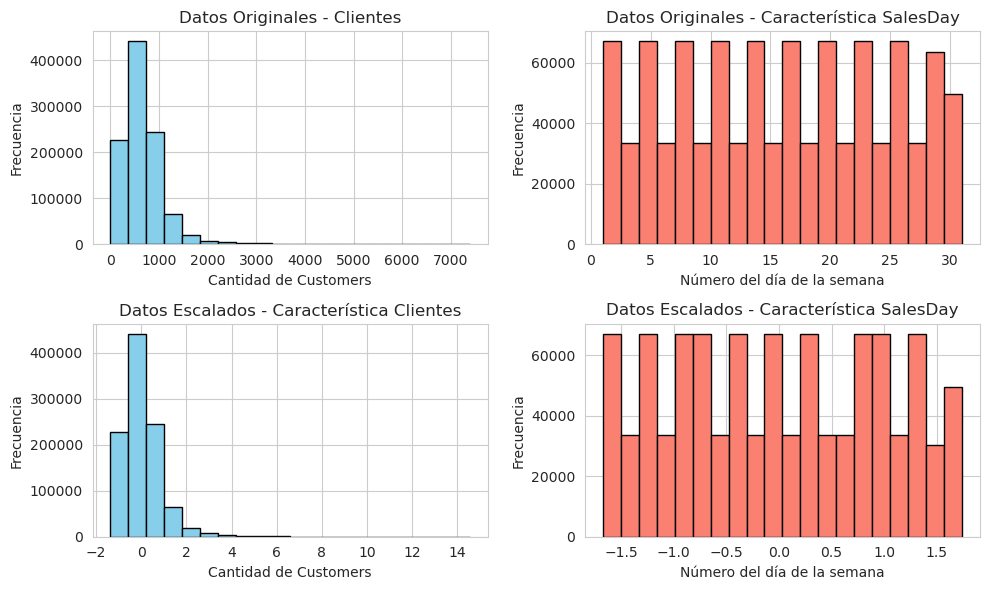

In [14]:
'''
En el siguiente código ejecutamos todas las herramientas antes comentadas para verificar su utilidad en el conjunto de datos.
'''
#Entrenamiento y transformación de los datos
data_turned = pipeline_preprocessor.fit_transform(enrichedMegaDF)
#Creación de un nuevo dataFrame para utilizar los datos transformados y extraer los valores transformados de las características elegidas
df_data_turned = pd.DataFrame(data = data_turned, columns=columns_for_inference)
#Extracción de la característica Customers
df_data_turned_customers = df_data_turned['Customers']
#Extracción de la característica SalesDay
df_data_turned_storeType = df_data_turned['SalesDay']

#Preparación para la ejecución y creación de la evaluación visual de los datos transformados.
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Datos originales - Característica Customers
axs[0, 0].hist(enrichedMegaDF['Customers'], bins=20, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Datos Originales - Clientes')
axs[0, 0].set_xlabel('Cantidad de Customers')
axs[0, 0].set_ylabel('Frecuencia')

# Datos originales - Característica SalesDay
axs[0, 1].hist(enrichedMegaDF['SalesDay'], bins=20, color='salmon', edgecolor='black')
axs[0, 1].set_title('Datos Originales - Característica SalesDay')
axs[0, 1].set_xlabel('Número del día de la semana')
axs[0, 1].set_ylabel('Frecuencia')

# Datos escalados - Característica Customers
axs[1, 0].hist(df_data_turned_customers, bins=20, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Datos Escalados - Característica Clientes')
axs[1, 0].set_xlabel('Cantidad de Customers')
axs[1, 0].set_ylabel('Frecuencia')

# Datos escalados - Característica SalesDay
axs[1, 1].hist(df_data_turned_storeType, bins=20, color='salmon', edgecolor='black')
axs[1, 1].set_title('Datos Escalados - Característica SalesDay')
axs[1, 1].set_xlabel('Número del día de la semana')
axs[1, 1].set_ylabel('Frecuencia')

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Tras la ejecución y visualización del resultado de la transformación de los datos, observamos que el conjunto de datos para las características de Customers y SalesDay pasa de tener valores elevados y dispersos a valores con una media de cero y una desviación estándar de uno. 

## Evaluación de las características
La evaluación de las principales características tiene como objetivo reducir la dimensionalidad o la cantidad de componentes principales necesarios para explicar el valor de un dato categórico o numérico. Esta etapa es crucial en el preprocesamiento de datos por varias razones, entre ellas la reducción de cómputo, simplificación y rendimiento del modelo.

### PCA - Análisis de Componentes Principales
`PCA` es una herramienta de `Scikit-Learn` comúnmente utilizada para la reducción de dimensionalidad.  Está reduce las características manteniendo la varianza más significativa de los datos.  De manera que su ejecución obtiene como resultado y de forma ordenada el primer componente principal que captura la mayor parte de la varianza en los datos y así sucesivamente.

In [15]:
'''
- Este apartado de código hace so de las herramientas ColumnTransformer, SimpleImputer y StandardScaler, unificadas en la variable preprocessor.
- Adicional creamos una nueva Pipeline con la herramienta PCA con el objetivo de identificar las principales características de los datos.  Dentro de la estructura del modelado la herramienta PCA tendrá un alias de pca. 
- El parámetro n_components es establecido a 2 por establecer algún valor y posteriormente realizar una evaluación visual de los resultados obtenidos. 
'''
pipeline_pca_preprocessing = Pipeline(
    steps=[("preprocessor", pipeline_preprocessor), ("pca",PCA(n_components=4))]
)
pipeline_pca_preprocessing

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['StoreType', 'Assortment',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'DayOfWeek', 'Customers',
                                                   'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday', 'SalesDay',
                                                   'SalesMonth', 'SalesYear',
                                                   'PromoIntervalMonth1',
                                                   'PromoIntervalMonth2',
                                                   'PromoIntervalMonth3',
                                                   'PromoIntervalMonth4',
                                                   'CompetitionOpenSinceYear',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth'])])),
                ('pca', PCA(n_components=4))])

A continuación realizamos la ejecución de la herramienta PCA con solo cuatro del total de componentes más la unión de todas las anteriores herramientas comentadas.

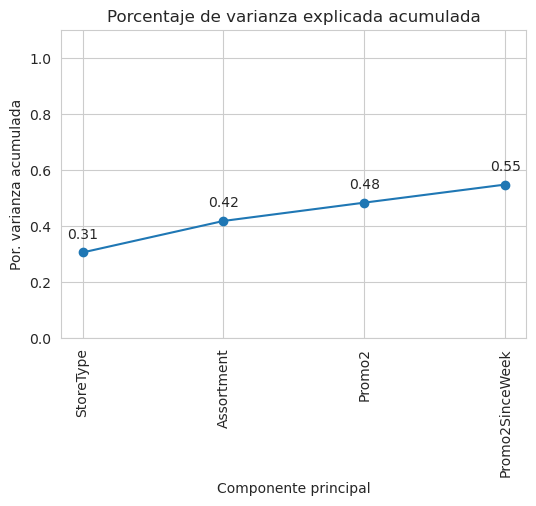

In [16]:
#Extracción de los datos evaluados
X = enrichedMegaDF[columns_for_inference]
#Extracción del dato a predecir.
Y = enrichedMegaDF[[column_to_predict]]
# Ajustar y transformar los datos
X_preprocessed = pipeline_pca_preprocessing.fit_transform(X)
#Estracción del modelado pca
modelo_pca = pipeline_pca_preprocessing.named_steps['pca']
#Debido al uso de las cuatro primeras componentes, así mismo es necesario extraer las columnas
columns = columns_for_inference[:4]
#Extracción de los datos de la varianza explicada
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
#Inicia con la grafica de la varianza
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_xticklabels(columns, rotation=90) 
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');
plt.show()

En la gráfica anterior vemos la varianza explicada con su equivalencia en porcentaje de los primeros cuatro componentes.  Si se empleasen únicamente estas componentes conseguiría el PCA explicar el 55% de la varianza observada, es posible afirmar con el uso de más componentes podría lograr mejores resultados, pero el uso de todos los componentes podría no significar lo esperado.

# Hiperparámetros
Después de construir el pipeline de preprocesamiento, comenzamos con la identificación de los mejores hiperparámetros para cada uno de los modelos seleccionados de la librería `Scikit-Learn`. Los modelos elegidos son los siguientes:

- **LinearRegression**: Seleccionado por su simplicidad y su capacidad predictiva rápida.
- **DecisionTreeRegressor**: Elegido por su robustez ante la variabilidad e inconsistencia de los datos.
- **Lasso**: Elegido por su rendimiento y capacidad para seleccionar características relevantes.
- **RandomForestRegressor**: Elegido por su robustez frente a valores atípicos y su alta precisión.

Para cada uno de los modelos, utilizaremos todas las características de los datos para predecir la variable objetivo. En algunos casos, los modelos tendrán parámetros preconfigurados con valores fijos y en otros utilizaremos la herramienta `GridSearchCV` de `Scikit-Learn` para optimizar los hiperparámetros.


**KFold**: Utilizaremos la técnica de validación cruzada `KFold` para identificar los mejores hiperparámetros. `KFold` divide los datos en múltiples particiones, creando varios conjuntos de entrenamiento y prueba. Esto permite evaluar el modelo de manera más robusta y reduce la posibilidad de sobreajuste al asegurar que el modelo se pruebe en diferentes subconjuntos de datos.

**GridSearchCV**: Esta herramienta realizará el entrenamiento del modelo probando todas las combinaciones posibles de los valores de los hiperparámetros. `GridSearchCV` utiliza `KFold` para evaluar el rendimiento de cada combinación, asegurando así que se identifiquen los hiperparámetros óptimos para el modelo. 

## Modelos

### LinearRegression
A continuación, creamos la pipeline para el modelo de regresión lineal.  Este modelo estará compuesto por las siguientes partes:
- **pipeline_preprocessor**: Este pipeline cotiene la implementación de la herramienta ColumnTransformer, que a su vez utiliza la pipeline `pipeline_numeric_transformer`.
- **pipeline_numeric_transformer**: Este pipeline incluye la implementación de las herramientas `SimpleImputer` y `StandardScaler` para mejorar los valores faltantes y estandarízar los datos.
- **PCA**: Esta herramienta reducirá la dimensionalidad del conjunto de los datos, gestionando la cantidad de componentes necesarios para la variable objetivo.

Finalmente, utilizaremos toda la pipeline completa con la biblioteca `GridSearchCV` para identificar los mejores hiperparámetros del modelo. 

In [17]:
'''
Este bloque de código esta compuesto por tres principales atributos:
* pipeline_linear_regression: Este es el pipeline el modelo LinearRegression.
* param_grid_linear_regression: Definición de los parámetros de valores posibles para los hiperparametros.
* pipeline_grid_search_linear_regression: Esta es la pipeline de la herramienta GridSearchCV. 
'''
#Creación del pipeline
pipeline_linear_regression = Pipeline(
    steps=[("preprocessor", pipeline_preprocessor), ("pca",PCA()), ("clf", LinearRegression())]
)
#Definición de los parámetros para la búsqueda de los hiperparámetros
param_grid_linear_regression = {'pca__n_components': [1, 2, 4, 6, 8, 10, 12, 14, 16, 19]}

# Búsqueda por grid search con validación cruzada r2
# ==============================================================================
pipeline_grid_search_linear_regression = GridSearchCV(
        #pipeline del modelo
        estimator  = pipeline_linear_regression,
        #listado de los valores de los parámetros
        param_grid = param_grid_linear_regression,
        #metricas elegidas para la validación
        scoring    = scoring,
        #Parametro para limitar la cantidad de nucleos de cpu
        n_jobs     = multiprocessing.cpu_count() - 1,
        #Definición del kfold estableciendo una división de los datos en 5 conjuntos.
        cv         = KFold(n_splits=5, random_state=pipeline_random_state, shuffle=True), 
        #evaluación global con r2
        refit      = 'r2',
        #Obtener información adicional de la evaluación.
        verbose    = 1,
        #Obtener las puntuaciones del entrenamiento
        return_train_score = True
       )

pipeline_grid_search_linear_regression

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['StoreType',
                                                                          'Assortment',
                                                                          'Promo2',
                                                                          'Promo2SinceWeek',
                                                                          'Promo2SinceYear',
                                                                          'DayOfWeek',
                                                                          'Customers',
                                                                          'Open',
                                                                          'Promo',
                                                                          'Stat...
                                                                          'PromoIntervalMonth3',
                                                                          'PromoIntervalMonth4',
                                                                          'CompetitionOpenSinceYear',
                                                                          'CompetitionDistance',
                                                                          'CompetitionOpenSinceMonth'])])),
                                       ('pca', PCA()),
                                       ('clf', LinearRegression())]),
             n_jobs=7,
             param_grid={'pca__n_components': [1, 2, 4, 6, 8, 10, 12, 14, 16,
                                               19]},
             refit='r2', return_train_score=True,
             scoring={'mae': 'neg_mean_squared_error', 'r2': 'r2',
                      'rmae': 'neg_root_mean_squared_error'},
             verbose=1)

### Lasso
A continuación, creamos la pipeline para el modelo Lasso.  Este modelo estará compuesto por las siguientes partes:
- **pipeline_preprocessor**: Este pipeline cotiene la implementación de la herramienta ColumnTransformer, que a su vez utiliza la pipeline `pipeline_numeric_transformer`.
- **pipeline_numeric_transformer**: Este pipeline incluye la implementación de las herramientas `SimpleImputer` y `StandardScaler` para mejorar los valores faltantes y estandarízar los datos.
- **PCA**: Esta herramienta reducirá la dimensionalidad del conjunto de los datos, gestionando la cantidad de componentes necesarios para la variable objetivo.

Finalmente, utilizaremos toda la pipeline completa con la biblioteca `GridSearchCV` para identificar los mejores hiperparámetros del modelo. 

In [18]:
'''
Este bloque de código esta compuesto por tres principales atributos:
* pipeline_lasso: Este es el pipeline del modelo Lasso.
* param_grid_lasso: Definición de los parámetros de valores posibles para los hiperparametros.
* pipeline_grid_search_lasso: Esta es la pipeline de la herramienta GridSearchCV. 
'''
#Creación del pipeline
pipeline_lasso = Pipeline(
    steps=[("preprocessor", pipeline_preprocessor), ("pca",PCA()), ("clf", Lasso(random_state=pipeline_random_state))]
)
#Definición de los parámetros para la búsqueda de los hiperparámetros
param_grid_lasso =  {'pca__n_components': [2, 4, 6, 8, 12, 16,19],
              'clf__alpha':[1,2,3,4,5,6,7,8,9,10],
              'clf__selection':['cyclic'],
              'clf__tol':[1e-5, 1e-4, 1e-3, 1e-2],
              'clf__max_iter':[5,10,20,30,40,50]}

# Búsqueda por grid search con validación cruzada r2
# ==============================================================================
pipeline_grid_search_lasso = GridSearchCV(
        #pipeline del modelo
        estimator  = pipeline_lasso,
        #listado de los valores de los parámetros
        param_grid = param_grid_lasso,
        #metricas elegidas para la validación
        scoring    = scoring,
        #Parametro para limitar la cantidad de nucleos de cpu
        n_jobs     = multiprocessing.cpu_count() - 1,
        #Definición del kfold estableciendo una división de los datos en 5 conjuntos.
        cv         = KFold(n_splits=5, random_state=pipeline_random_state, shuffle=True), 
        #evaluación global con r2
        refit      = 'r2',
        #Obtener información adicional de la evaluación.
        verbose    = 0,
        #Obtener las puntuaciones del entrenamiento
        return_train_score = True
       )

pipeline_grid_search_lasso

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['StoreType',
                                                                          'Assortment',
                                                                          'Promo2',
                                                                          'Promo2SinceWeek',
                                                                          'Promo2SinceYear',
                                                                          'DayOfWeek',
                                                                          'Customers',
                                                                          'Open',
                                                                          'Promo',
                                                                          'Stat...
                                       ('clf', Lasso(random_state=42))]),
             n_jobs=7,
             param_grid={'clf__alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'clf__max_iter': [5, 10, 20, 30, 40, 50],
                         'clf__selection': ['cyclic'],
                         'clf__tol': [1e-05, 0.0001, 0.001, 0.01],
                         'pca__n_components': [2, 4, 6, 8, 12, 16, 19]},
             refit='r2', return_train_score=True,
             scoring={'mae': 'neg_mean_squared_error', 'r2': 'r2',
                      'rmae': 'neg_root_mean_squared_error'})

### DecisionTreeRegressor
A continuación, creamos la pipeline para el modelo DecisionTreeRegressor.  Este modelo estará compuesto por las siguientes partes:
- **pipeline_preprocessor**: Este pipeline cotiene la implementación de la herramienta ColumnTransformer, que a su vez utiliza la pipeline `pipeline_numeric_transformer`.
- **pipeline_numeric_transformer**: Este pipeline incluye la implementación de las herramientas `SimpleImputer` y `StandardScaler` para mejorar los valores faltantes y estandarízar los datos.
- **PCA**: Esta herramienta reducirá la dimensionalidad del conjunto de los datos, gestionando la cantidad de componentes necesarios para la variable objetivo.

Finalmente, utilizaremos toda la pipeline completa con la biblioteca `GridSearchCV` para identificar los mejores hiperparámetros del modelo. 

In [19]:
'''
Este bloque de código esta compuesto por tres principales atributos:
* pipeline_decision_treeRegressor: Este es el pipeline del modelo DecisionTreeRegressor.
* param_grid_decision_treeRegressor: Definición de los parámetros de valores posibles para los hiperparametros.
* pipeline_grid_search_decision_treeRegressor: Esta es la pipeline de la herramienta GridSearchCV. 
'''
#Creación del pipeline
pipeline_decision_treeRegressor = Pipeline(
    steps=[("preprocessor", pipeline_preprocessor), ("pca",PCA()), ("clf", DecisionTreeRegressor(random_state=pipeline_random_state))]
)
#Definición de los parámetros para la búsqueda de los hiperparámetros
param_grid_decision_treeRegressor =  {'pca__n_components': [2, 4, 6, 8, 12, 16, 19],
              'clf__max_depth':[None, 15, 16],
              'clf__min_samples_split':[2, 4, 6, 8],
              'clf__min_samples_leaf':[1,2,3]}

# Búsqueda por grid search con validación cruzada r2
# ==============================================================================
pipeline_grid_search_decision_treeRegressor = GridSearchCV(
        #pipeline del modelo
        estimator  = pipeline_decision_treeRegressor,
        #listado de los valores de los parámetros
        param_grid = param_grid_decision_treeRegressor,
        #metricas elegidas para la validación
        scoring    = scoring,
        #Parametro para limitar la cantidad de nucleos de cpu
        n_jobs     = multiprocessing.cpu_count() - 1,
        #Definición del kfold estableciendo una división de los datos en 5 conjuntos.
        cv         = KFold(n_splits=5, random_state=pipeline_random_state, shuffle=True), 
        #evaluación global con r2
        refit      = 'r2',
        #Obtener información adicional de la evaluación.
        verbose    = 0,
        #Obtener las puntuaciones del entrenamiento
        return_train_score = True
       )

pipeline_grid_search_decision_treeRegressor

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['StoreType',
                                                                          'Assortment',
                                                                          'Promo2',
                                                                          'Promo2SinceWeek',
                                                                          'Promo2SinceYear',
                                                                          'DayOfWeek',
                                                                          'Customers',
                                                                          'Open',
                                                                          'Promo',
                                                                          'Stat...
                                                                          'CompetitionOpenSinceMonth'])])),
                                       ('pca', PCA()),
                                       ('clf',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=7,
             param_grid={'clf__max_depth': [None, 15, 16],
                         'clf__min_samples_leaf': [1, 2, 3],
                         'clf__min_samples_split': [2, 4, 6, 8],
                         'pca__n_components': [2, 4, 6, 8, 12, 16, 19]},
             refit='r2', return_train_score=True,
             scoring={'mae': 'neg_mean_squared_error', 'r2': 'r2',
                      'rmae': 'neg_root_mean_squared_error'})

### RandomForestRegressor
A continuación, creamos la pipeline para el modelo RandomForestRegressor.  Este modelo estará compuesto por las siguientes partes:
- **pipeline_preprocessor**: Este pipeline cotiene la implementación de la herramienta ColumnTransformer, que a su vez utiliza la pipeline `pipeline_numeric_transformer`.
- **pipeline_numeric_transformer**: Este pipeline incluye la implementación de las herramientas `SimpleImputer` y `StandardScaler` para mejorar los valores faltantes y estandarízar los datos.
- **PCA**: Esta herramienta reducirá la dimensionalidad del conjunto de los datos, gestionando la cantidad de componentes necesarios para la variable objetivo.

Finalmente, utilizaremos toda la pipeline completa con la biblioteca `GridSearchCV` para identificar los mejores hiperparámetros del modelo.

In [20]:
'''
Este bloque de código esta compuesto por tres principales atributos:
* pipeline_randomforest_regressor: Este es el pipeline del modelo DecisionTreeRegressor.
* param_grid_randomforest_regressor: Definición de los parámetros de valores posibles para los hiperparametros.
* pipeline_grid_search_randomforest_regressor: Esta es la pipeline de la herramienta GridSearchCV. 
'''
#Creación del pipeline
pipeline_randomforest_regressor = Pipeline(
    steps=[("preprocessor", pipeline_preprocessor), ("pca",PCA()), ("clf", RandomForestRegressor(random_state=pipeline_random_state))]
)
#Definición de los parámetros para la búsqueda de los hiperparámetros
param_grid_randomforest_regressor =  {'pca__n_components': [2, 4, 6, 8, 12, 16,19],
              'clf__n_estimators':[1,5,10]}

# Búsqueda por grid search con validación cruzada r2
# ==============================================================================
pipeline_grid_search_randomforest_regressor = GridSearchCV(
        #pipeline del modelo
        estimator  = pipeline_randomforest_regressor,
        #listado de los valores de los parámetros
        param_grid = param_grid_randomforest_regressor,
        #metricas elegidas para la validación
        scoring    = scoring,
        #Parametro para limitar la cantidad de nucleos de cpu
        n_jobs     = multiprocessing.cpu_count() - 1,
        #Definición del kfold estableciendo una división de los datos en 5 conjuntos.
        cv         = KFold(n_splits=5, random_state=pipeline_random_state, shuffle=True), 
        #evaluación global con r2
        refit      = 'r2',
        #Obtener información adicional de la evaluación.
        verbose    = 0,
        #Obtener las puntuaciones del entrenamiento
        return_train_score = True
       )

pipeline_grid_search_randomforest_regressor

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['StoreType',
                                                                          'Assortment',
                                                                          'Promo2',
                                                                          'Promo2SinceWeek',
                                                                          'Promo2SinceYear',
                                                                          'DayOfWeek',
                                                                          'Customers',
                                                                          'Open',
                                                                          'Promo',
                                                                          'Stat...
                                                                          'CompetitionOpenSinceYear',
                                                                          'CompetitionDistance',
                                                                          'CompetitionOpenSinceMonth'])])),
                                       ('pca', PCA()),
                                       ('clf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=7,
             param_grid={'clf__n_estimators': [1, 5, 10],
                         'pca__n_components': [2, 4, 6, 8, 12, 16, 19]},
             refit='r2', return_train_score=True,
             scoring={'mae': 'neg_mean_squared_error', 'r2': 'r2',
                      'rmae': 'neg_root_mean_squared_error'})

## Ejecución conjunta de los modelos
Este apartado está compuesto por dos partes:
**Parte 1**: Creación de una lista con todos los pipelines para cada uno de los modelos LinearRegression, Lasso, DecisionTreeRegressor y RandomForestRegressor.
**Parte 2**: La ejecución controlada de cada modelo, resgistro de sus resultados en MlFlow y creación de un fichero con los resultados de cada una de las evaluciones. 

In [21]:
prediction_models_to_evaluate = [
    (pipeline_grid_search_linear_regression, 'Linear Regression'),
    (pipeline_grid_search_lasso, 'Lasso'),
    (pipeline_grid_search_decision_treeRegressor,'Decision TreeRegressor'),
    (pipeline_grid_search_randomforest_regressor,'RandomForest TreeRegressor')
]

In [22]:
symbols = ["⢎⡰", "⢎⡡", "⢎⡑", "⢎⠱", "⠎⡱", "⢊⡱", "⢌⡱", "⢆⡱"]
no_use_case = 1
no_total_use_cases = len(windows) * len(percents_by_windows)
all_results_models = []
print("#########################################################")
print("# EVALUADOR DE MODELOS EN EJECUCIÓN - POR FAVOR, ESPERE #")      
print("#########################################################")
print("")
# Recorremos todas las ventanas temporales
for window in windows:    
    index_percent = 0
    for percent_of_returned_rows in percents_by_windows:     
        symbol = symbols[no_use_case % len(symbols)]
        last_no_days = window
        # Obtenemos un DataFrame preparado para esta Ventana de Tiempo y
        # para el porcentaje de datos asociado
        useCaseDF = \
            adjustDataFrameForUseCase(enrichedMegaDF, 
                                      last_no_days, 
                                      percent_of_returned_rows)        
        # Obtenemos los DataFrames de entrenamiento y test para ejecutar el
        # modelo
        X_train, X_test, Y_train, Y_test = \
            getDataFramesForTrainAndTest(useCaseDF, 
                                        percent_train, 
                                        columns_for_inference, 
                                        column_to_predict)
        # Creamos un identificador único para cada ventana
        id_use_case = "W" + str(window) + "P" + str(percent_of_returned_rows * 100)
        for i, (model, name) in enumerate(prediction_models_to_evaluate):
            
            data_percent = str(percent_of_returned_rows * 100)
            print(f"\r                                                                                                                        ", end="")
            print(f"\r{symbol} [{no_use_case} / {no_total_use_cases}] - Modelo [ {name} ] - Ventana [{window} días] - Datos [{data_percent} %]", end="")
            print('')
            #Entrenamiento del modelo
            model.fit(X = X_train, y = Y_train)
            print(f'\rModelo [ {name} ] entrenado')
            
            #Extracción de los resultados del entramiento del modelo
            resultados = pd.DataFrame(model.cv_results_)
            resultados.filter(regex = '(param.*|mean_t|std_t)') \
                .drop(columns = 'params') \
                .sort_values('mean_test_r2', ascending = False)
            # Almacenamos detalles de la ejecución
            resultados['Model'] = name
            resultados["window"] = window
            resultados["data_size"] = str(percent_of_returned_rows * 100)
            resultados["use_case"] = id_use_case        
            # Almacenamos el tamaño de los conjuntos de entrenamiento y test
            resultados["x_train_size"] = len(X_train)
            resultados["y_train_size"] = len(Y_train)
            resultados["x_test_size"] = len(X_test)
            resultados["y_test_size"] = len(Y_test)
            #registra para exportación los resultados
            all_results_models.append(resultados)
            #registra los resultados en mlflow
            # mlflowLoadRun(model,name,id_use_case,X_train, X_test,Y_test)
            # print(f'\rModelo [ {name} ] registrado en MlFlow')
            
           
            
        index_percent += 1
        no_use_case += 1

df_all_results_models = pd.concat(all_results_models)
file_name = os.path.join(data_directory, csv_evaluation_resume)
df_all_results_models.to_csv(file_name, encoding='utf-8', index=False)
display(df_all_results_models)

#########################################################
# EVALUADOR DE MODELOS EN EJECUCIÓN - POR FAVOR, ESPERE #
#########################################################

⢎⡡ [1 / 2] - Modelo [ Linear Regression ] - Ventana [7 días] - Datos [80.0 %]                                           
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo [ Linear Regression ] entrenado
⢎⡡ [1 / 2] - Modelo [ Lasso ] - Ventana [7 días] - Datos [80.0 %]                                                       
Modelo [ Lasso ] entrenado
⢎⡡ [1 / 2] - Modelo [ Decision TreeRegressor ] - Ventana [7 días] - Datos [80.0 %]                                      
Modelo [ Decision TreeRegressor ] entrenado
⢎⡡ [1 / 2] - Modelo [ RandomForest TreeRegressor ] - Ventana [7 días] - Datos [80.0 %]                                  


Modelo [ RandomForest TreeRegressor ] entrenado
⢎⡑ [2 / 2] - Modelo [ Linear Regression ] - Ventana [90 días] - Datos [80.0 %]                                          
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo [ Linear Regression ] entrenado
⢎⡑ [2 / 2] - Modelo [ Lasso ] - Ventana [90 días] - Datos [80.0 %]                                                      
Modelo [ Lasso ] entrenado
⢎⡑ [2 / 2] - Modelo [ Decision TreeRegressor ] - Ventana [90 días] - Datos [80.0 %]                                     
Modelo [ Decision TreeRegressor ] entrenado
⢎⡑ [2 / 2] - Modelo [ RandomForest TreeRegressor ] - Ventana [90 días] - Datos [80.0 %]                                 


Modelo [ RandomForest TreeRegressor ] entrenado


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,x_test_size,y_test_size,param_clf__alpha,param_clf__max_iter,param_clf__selection,param_clf__tol,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators
0,0.100936,0.036333,0.028483,0.016955,1,{'pca__n_components': 1},0.030312,0.004891,0.028423,0.021971,...,1249,1249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.107236,0.045478,0.037481,0.024673,2,{'pca__n_components': 2},0.586069,0.585062,0.595607,0.552006,...,1249,1249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.145160,0.039011,0.041495,0.021324,4,{'pca__n_components': 4},0.591718,0.591936,0.594295,0.559572,...,1249,1249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.129453,0.020255,0.026616,0.020575,6,{'pca__n_components': 6},0.713423,0.690173,0.725581,0.656950,...,1249,1249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.116975,0.046174,0.032611,0.014920,8,{'pca__n_components': 8},0.724095,0.720696,0.740473,0.671308,...,1249,1249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,18.583948,1.500558,0.149616,0.026151,6,"{'clf__n_estimators': 10, 'pca__n_components': 6}",0.860773,0.861882,0.858182,0.869623,...,16056,16056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
17,25.385489,2.096649,0.178747,0.113717,8,"{'clf__n_estimators': 10, 'pca__n_components': 8}",0.888888,0.896489,0.888128,0.896723,...,16056,16056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
18,35.032949,2.713711,0.130968,0.028775,12,"{'clf__n_estimators': 10, 'pca__n_components':...",0.900427,0.909738,0.905061,0.910578,...,16056,16056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
19,45.935422,1.983166,0.177800,0.033127,16,"{'clf__n_estimators': 10, 'pca__n_components':...",0.918950,0.925666,0.921351,0.927697,...,16056,16056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
